In [2]:
import csv

# Generate filenames programmatically
path = (
    "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTBBE/1000simNoXgb2000mData"
)
files = [path + "/getXGBoostTrainingData_{}.csv".format(i) for i in range(1000)]

merged_filename = "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTraining/dataXgb1_2000m/XGB_merged_result.csv"

with open(merged_filename, "w", newline="") as outfile:
    writer = csv.writer(outfile)

    for index, filename in enumerate(files):
        with open(filename, "r") as infile:
            reader = csv.reader(infile)

            # Skip header only if it's not the first file
            if index != 0:
                next(reader, None)

            # Write rows from current file to the output file
            writer.writerows(reader)

In [3]:
import pandas as pd

# Read the merged CSV file into a DataFrame
df = pd.read_csv(
    "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTraining/dataXgb1_2000m/XGB_merged_result.csv"
)

# Sort the DataFrame by balance in descending order
df_sorted = df.sort_values(by="balance", ascending=False)

df_sorted.head(100)

,type,competitorID,time,exchange,odds,agentID,stake,distance,rank,balance,decision
6331809,Trade,4,46.405968,0,4.718916,50,15,539.303349,1,1.000623e+08,layer
6334793,Trade,4,157.040155,0,4.421457,50,15,1821.809311,2,1.000623e+08,layer
6334811,Trade,4,157.050731,0,4.421457,50,15,1821.809311,2,1.000623e+08,layer
6334809,Trade,4,157.050134,0,4.421457,50,15,1821.809311,2,1.000623e+08,layer
6334807,Trade,4,157.049467,0,4.421457,50,15,1821.809311,2,1.000623e+08,layer
...,...,...,...,...,...,...,...,...,...,...,...
6334941,Trade,4,157.114060,0,4.049295,50,15,1836.424763,2,1.000623e+08,layer
6338583,Trade,4,159.173769,0,4.518916,50,15,1862.001805,2,1.000623e+08,layer
6334853,Trade,4,157.069854,0,4.049295,50,15,1821.809311,2,1.000623e+08,layer
6334935,Trade,4,157.109531,0,4.049295,50,15,1836.424763,2,1.000623e+08,layer


In [4]:
# Calculate 20% of the total number of rows and retrieve the top rows
top_20_percent = int(0.20 * len(df_sorted))
top_20_df = df_sorted.head(top_20_percent)

# Save the top 20% rows to a new CSV file, if desired
top_20_df.to_csv(
    "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTraining/dataXgb1_2000m/XGB_Top_20%.csv",
    index=False,
)

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Import the data
data = pd.read_csv(
    "/Volumes/Kingston XS2000 Media/XGBoost_OD_TBBE/XGBoostTraining/dataXgb1_2000m/XGB_Top_20%.csv"
)
decision_counts = data["decision"].value_counts()
print(decision_counts)


# Remove potentially irrelevant columns
data = data.drop(
    columns=["type", "competitorID", "exchange", "agentID", "balance", "odds"]
)

# Column that has left: time  odds  stake  distance  rank

# Convert 'decision' column to binary: 1 for 'backer' and 0 for 'layer'
data["decision"] = data["decision"].map({"backer": 1, "layer": 0})

# Split data into training and testing sets
X = data.drop(columns="decision")
print(X.head())
y = data["decision"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

decision
layer     1414090
backer     121670
Name: count, dtype: int64
         time  stake     distance  rank
0   46.405968     15   539.303349     1
1  157.040155     15  1821.809311     2
2  157.050731     15  1821.809311     2
3  157.050134     15  1821.809311     2
4  157.049467     15  1821.809311     2


In [3]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


# Define the function to optimize
def bo_tune_xgb(eta, max_depth, subsample, colsample_bytree, gamma, alpha, lambda_):
    params = {
        "eta": eta,
        "max_depth": int(max_depth),
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "gamma": gamma,
        "alpha": alpha,
        "lambda": lambda_,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_estimators": 100,
        "random_state": 42,
    }
    cv_result = xgb.cv(params, dtrain, nfold=5)
    y_pred = xgb.train(params, dtrain, num_boost_round=100).predict(xgb.DMatrix(X_test))
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]  # Apply threshold
    return accuracy_score(y_test, y_pred)


# Convert training data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the bounds of the hyperparameters to optimize
hyperparameter_space = {
    "eta": (0.1, 0.6),
    "max_depth": (5, 8),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "gamma": (0, 0.4),
    "alpha": (0, 2.0),
    "lambda_": (0, 3.0),
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=bo_tune_xgb, pbounds=hyperparameter_space, random_state=42, verbose=2
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=50)

# Print best parameters and score
print("Best parameters found:", optimizer.max["params"])
print("Best cross-validation score:", optimizer.max["target"])

# Use the best model for prediction and evaluation
best_params = optimizer.max["params"]
best_params["max_depth"] = int(best_params["max_depth"])
best_model = xgb.train(best_params, dtrain, num_boost_round=100)

y_pred_best = best_model.predict(xgb.DMatrix(X_test))
y_pred_best = [1 if pred > 0.5 else 0 for pred in y_pred_best]  # Apply threshold
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy (Best Model):", accuracy_best)
print(classification_report(y_test, y_pred_best))

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambda_  | max_depth | subsample |
-------------------------------------------------------------------------------------------------------------


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:32:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:32:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 1         | 0.9494    | 0.7491    | 0.9754    | 0.466     | 0.2395    | 0.4681    | 5.468     | 0.529     |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 2         | 0.9527    | 1.732     | 0.8006    | 0.454     | 0.008234  | 2.91      | 7.497     | 0.6062    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 3         | 0.9439    | 0.3636    | 0.5917    | 0.2521    | 0.2099    | 1.296     | 5.874     | 0.8059    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 4         | 0.9442    | 0.279     | 0.6461    | 0.2832    | 0.1824    | 2.356     | 5.599     | 0.7571    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 5         | 0.9501    | 1.185     | 0.5232    | 0.4038    | 0.06821   | 0.1952    | 7.847     | 0.9828    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 6         | 0.9541    | 1.92      | 0.7529    | 0.4819    | 0.0       | 2.185     | 8.0       | 0.6826    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 7         | 0.9554    | 0.781     | 1.0       | 0.6       | 0.4       | 2.296     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 8         | 0.9438    | 0.0       | 0.5       | 0.1       | 0.0       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 9         | 0.9554    | 1.278     | 1.0       | 0.6       | 0.4       | 1.521     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 10        | 0.9536    | 2.0       | 1.0       | 0.6       | 0.4       | 1.662     | 6.992     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 11        | 0.9525    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 5.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 12        | 0.952     | 2.0       | 1.0       | 0.6       | 0.0       | 3.0       | 5.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 13        | 0.9516    | 1.517     | 1.0       | 0.1       | 0.4       | 2.186     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 14        | 0.9559    | 0.1505    | 1.0       | 0.6       | 0.4       | 1.312     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 15        | 0.9561    | 0.0       | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:36:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 16        | 0.9548    | 0.0       | 1.0       | 0.6       | 0.4       | 0.0       | 7.034     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 17        | 0.9538    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 6.562     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 18        | 0.9556    | 0.715     | 1.0       | 0.6       | 0.0       | 1.606     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 19        | 0.9558    | 0.0       | 1.0       | 0.6       | 0.0       | 0.5847    | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 20        | 0.9557    | 0.569     | 1.0       | 0.6       | 0.4       | 0.624     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 21        | 0.9555    | 2.0       | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 22        | 0.9554    | 2.0       | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 23        | 0.9555    | 2.0       | 1.0       | 0.6       | 0.0       | 0.9409    | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 24        | 0.9562    | 2.0       | 1.0       | 0.6       | 0.0       | 1.637     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 25        | 0.9548    | 2.0       | 1.0       | 0.6       | 0.4       | 2.494     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 26        | 0.956     | 0.0       | 1.0       | 0.6       | 0.4       | 0.5724    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 27        | 0.955     | 2.0       | 1.0       | 0.6       | 0.4       | 0.0       | 7.291     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 28        | 0.9552    | 0.0       | 1.0       | 0.6       | 0.4       | 0.6148    | 7.694     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:40:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 29        | 0.9527    | 0.0       | 1.0       | 0.1       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 30        | 0.9554    | 2.0       | 1.0       | 0.6       | 0.4       | 0.9259    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 31        | 0.9553    | 2.0       | 1.0       | 0.6       | 0.4       | 1.72      | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 32        | 0.9517    | 0.0       | 0.5       | 0.6       | 0.4       | 0.3959    | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 33        | 0.9549    | 2.0       | 1.0       | 0.6       | 0.4       | 0.4518    | 7.395     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 34        | 0.9555    | 0.6134    | 1.0       | 0.6       | 0.4       | 1.487     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 35        | 0.9554    | 2.0       | 1.0       | 0.6       | 0.0       | 2.559     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 36        | 0.9559    | 0.4114    | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 37        | 0.9556    | 0.5647    | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 38        | 0.9549    | 0.9958    | 1.0       | 0.6       | 0.4       | 0.0       | 7.433     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 39        | 0.9556    | 0.0       | 1.0       | 0.6       | 0.0       | 0.0       | 7.682     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 40        | 0.9559    | 0.0       | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 41        | 0.9563    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 42        | 0.9558    | 2.0       | 1.0       | 0.6       | 0.0       | 1.031     | 7.512     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 43        | 0.9563    | 1.41      | 1.0       | 0.6       | 0.0       | 1.13      | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 44        | 0.9566    | 0.5332    | 1.0       | 0.6       | 0.0       | 0.828     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 45        | 0.9552    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 7.675     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 46        | 0.9565    | 0.9909    | 1.0       | 0.6       | 0.0       | 0.5823    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 47        | 0.9562    | 2.0       | 1.0       | 0.6       | 0.0       | 0.5238    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 48        | 0.9564    | 1.427     | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 49        | 0.9562    | 1.572     | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 50        | 0.9565    | 0.8586    | 1.0       | 0.6       | 0.0       | 0.9762    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 51        | 0.9564    | 0.6762    | 1.0       | 0.6       | 0.2304    | 0.7572    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 52        | 0.9564    | 1.475     | 1.0       | 0.6       | 0.0       | 0.4813    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 53        | 0.9564    | 0.0       | 1.0       | 0.6       | 0.0       | 1.062     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:50:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 54        | 0.9557    | 0.781     | 1.0       | 0.6       | 0.0       | 0.7862    | 7.785     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:50:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 55        | 0.9564    | 0.0       | 1.0       | 0.6       | 0.0       | 0.6202    | 8.0       | 1.0       |
Best parameters found: {'alpha': 0.5331598718008485, 'colsample_bytree': 1.0, 'eta': 0.6, 'gamma': 0.0, 'lambda_': 0.8280177869812716, 'max_depth': 8.0, 'subsample': 1.0}
Best cross-validation score: 0.9566338490389124


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (Best Model): 0.956653383341147
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    282699
           1       0.88      0.53      0.66     24453

    accuracy                           0.96    307152
   macro avg       0.92      0.76      0.82    307152
weighted avg       0.95      0.96      0.95    307152



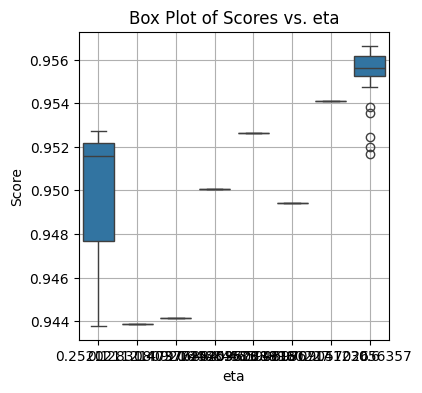

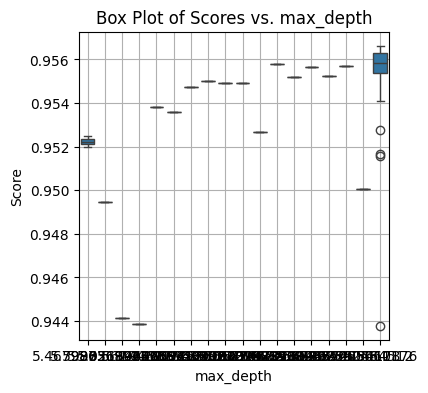

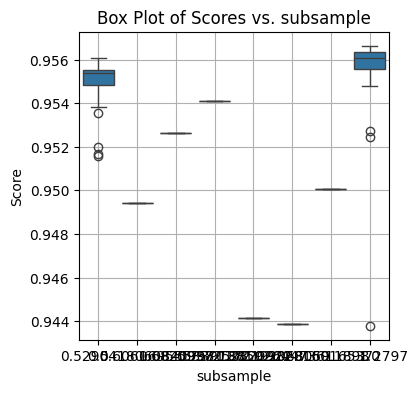

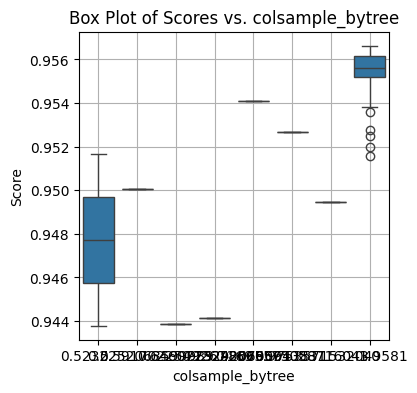

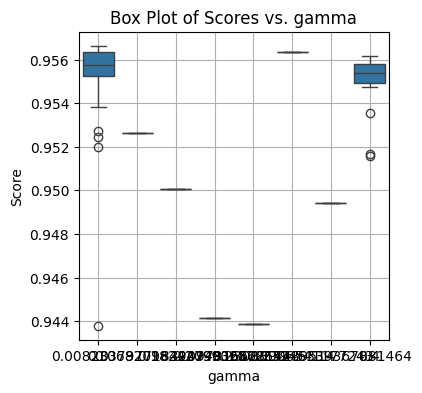

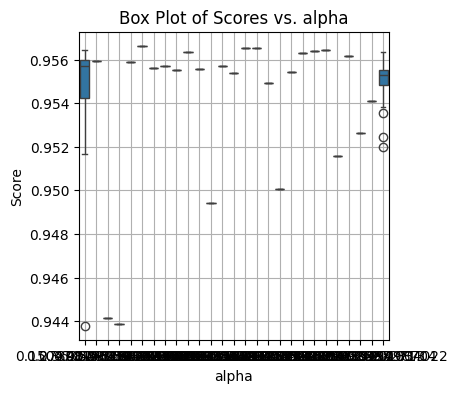

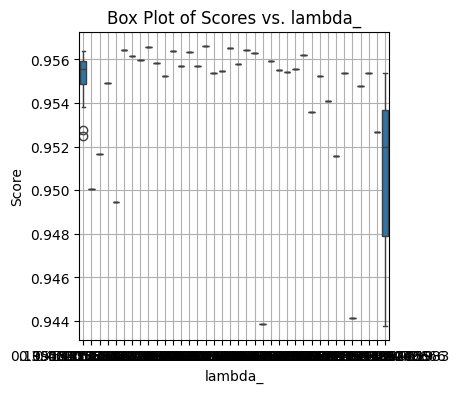

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the optimization results to a dataframe
results_df = pd.DataFrame(optimizer.res)

# Extract the parameters into separate columns
for param in hyperparameter_space.keys():
    results_df[param] = results_df["params"].apply(lambda params: params[param])

# Melt the dataframe for seaborn
melted_scores_df = results_df.melt(
    id_vars=list(hyperparameter_space.keys()),
    value_vars=["target"],
    var_name="iteration",
    value_name="score",
)

for param in hyperparameter_space.keys():
    plt.figure(figsize=(4, 4))

    # Boxplot
    sns.boxplot(data=melted_scores_df, x=param, y="score")
    plt.title(f"Box Plot of Scores vs. {param}")
    plt.ylabel("Score")
    plt.grid(True)
    plt.show()

Accuracy: 0.956653383341147

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    282699
           1       0.88      0.53      0.66     24453

    accuracy                           0.96    307152
   macro avg       0.92      0.76      0.82    307152
weighted avg       0.95      0.96      0.95    307152



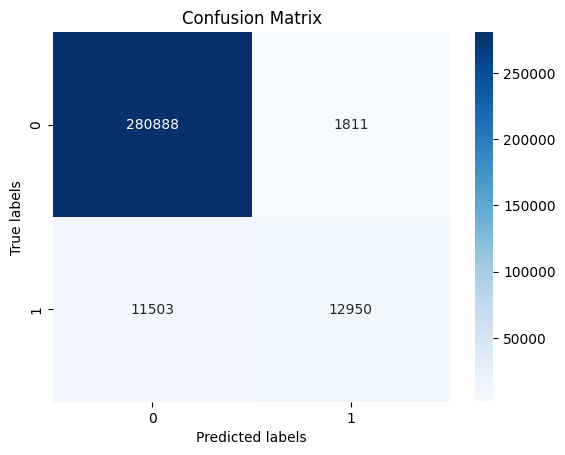

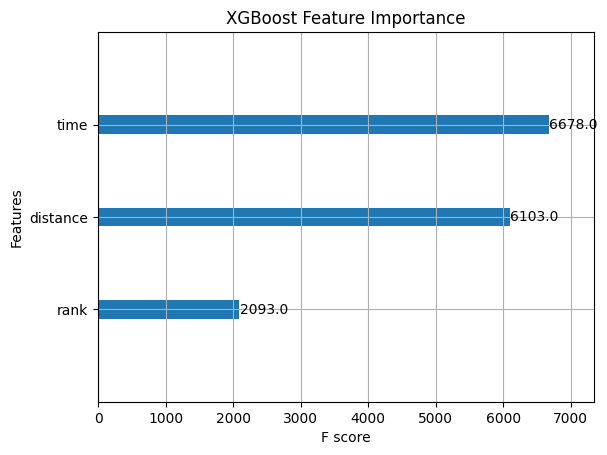

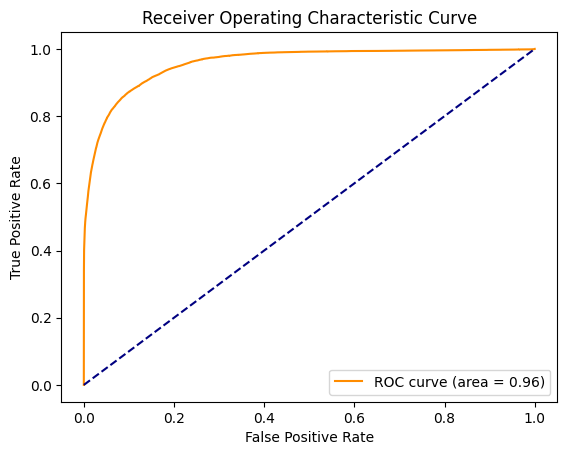

PR AUC: 0.7910852345010159


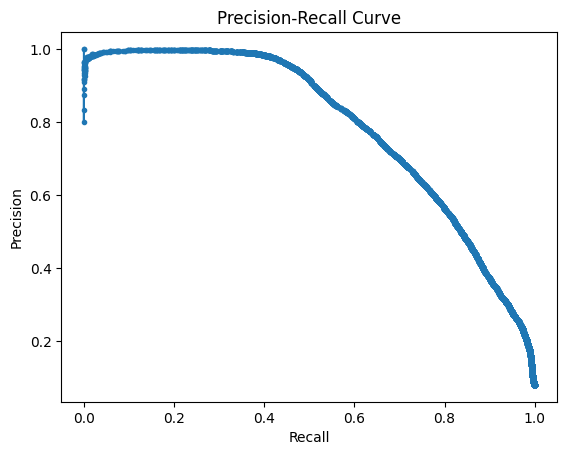

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import seaborn as sns
import joblib

# 1. Testing on the Test Set
y_pred = y_pred_best

# 2. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# 3. Visualization

# Feature Importance
xgb.plot_importance(best_model)
plt.title("XGBoost Feature Importance")
plt.show()

# ROC Curve
y_pred_proba = best_model.predict(xgb.DMatrix(X_test))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
# Compute and print AUC for Precision-Recall Curve
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc}")
plt.show()

Best parameters found: {'alpha': 0.5331598718008485, 'colsample_bytree': 1.0, 'eta': 0.6, 'gamma': 0.0, 'lambda_': 0.8280177869812716, 'max_depth': 8, 'subsample': 1.0}


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


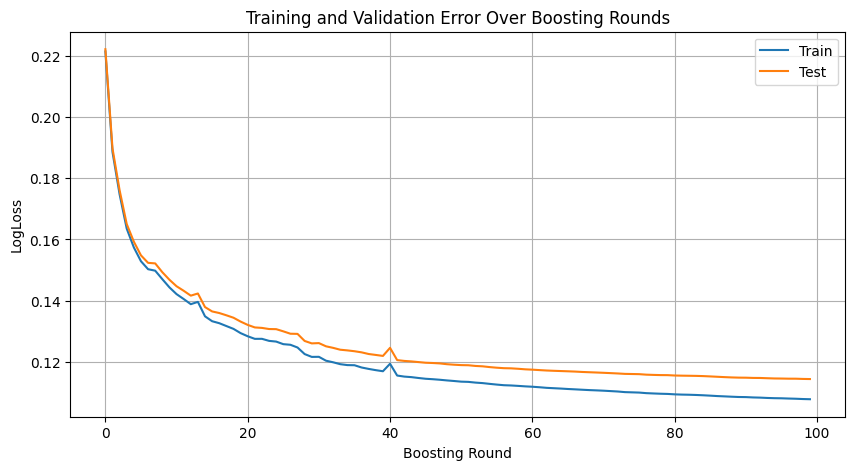

In [6]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Use the best parameters from the Bayesian optimization
print("Best parameters found:", best_params)

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic", random_state=42, n_estimators=100, **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=2000,  # Increasing n_estimators to 2000
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:53:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.5331598718008485, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.6, eval_metric='logloss',
              feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda_=0.8280177869812716, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, ...)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:54:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


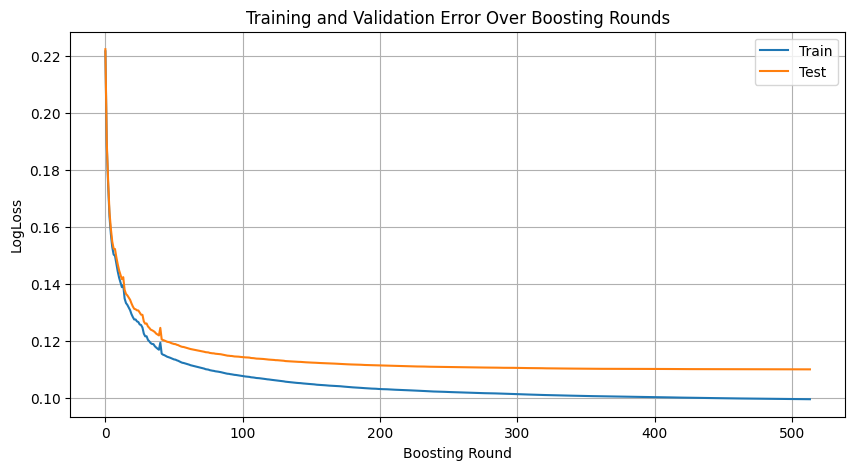

In [8]:
# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_estimators=2000,  # Increasing n_estimators to 2000
    **best_params,
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

# 1. Print the boosting round where early stopping occurred:
print(f"Best iteration: {best_xgb_estimator.get_booster().best_iteration}")

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.axvline(
    x=best_xgb_estimator.get_booster().best_iteration,
    color="gray",
    linestyle="--",
    label="Early Stopping Point",
)
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualize the model using XGBoost's plot functionalities:

# a. Plotting the first tree:
xgb.plot_tree(best_xgb_estimator, num_trees=0)
plt.show()

# b. Displaying the importance of each feature:
xgb.plot_importance(best_xgb_estimator)
plt.title("Feature Importance")
plt.show()

# Feature importances:
importances = best_xgb_estimator.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame(
    {"Feature": features, "Importance": importances}
).sort_values(by="Importance", ascending=False)
print(feature_importance_df)

NameError: name 'best_params' is not defined

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    282699
           1       0.85      0.56      0.68     24453

    accuracy                           0.96    307152
   macro avg       0.91      0.77      0.83    307152
weighted avg       0.95      0.96      0.95    307152

[[280383   2316]
 [ 10806  13647]]


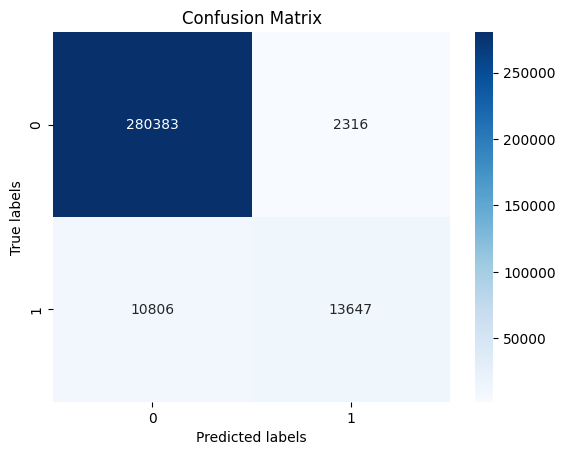

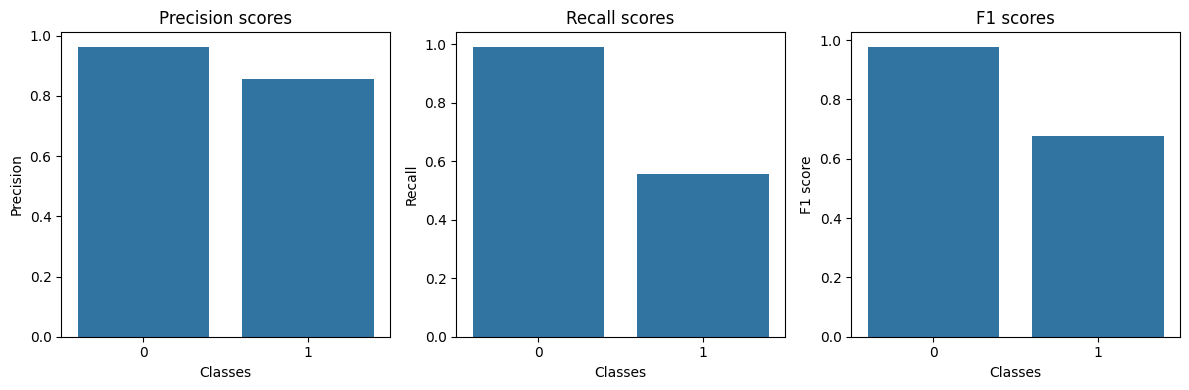

In [10]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict the classes
y_pred = best_xgb_estimator.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Precision, recall, f1-score plots for each class
precision, recall, f1score, _ = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

plt.figure(figsize=(12, 4))

plt.subplot(131)
sns.barplot(x=np.unique(y_test), y=precision)
plt.title("Precision scores")
plt.xlabel("Classes")
plt.ylabel("Precision")

plt.subplot(132)
sns.barplot(x=np.unique(y_test), y=recall)
plt.title("Recall scores")
plt.xlabel("Classes")
plt.ylabel("Recall")

plt.subplot(133)
sns.barplot(x=np.unique(y_test), y=f1score)
plt.title("F1 scores")
plt.xlabel("Classes")
plt.ylabel("F1 score")

plt.tight_layout()
plt.show()

In [11]:
# Save the best model to a .json file
best_model.save_model("Trained_XGB1_model.json")